# A 1D convolutional net in Keras
Very little preprocessing was needed. Batch normalization made a huge difference, and made it possible to achieve perfect classification within the Kaggle kernel.

In [1]:
#We import libraries for linear algebra, graphs, and evaluation of results
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.ndimage.filters import uniform_filter1d

C:\Users\vikas\AppData\Local\Temp\ipykernel_16880\2449683794.py:7: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


In [2]:
#Keras is a high level neural networks library, based on either tensorflow or theano
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten, \
BatchNormalization, Input, concatenate, Activation
from keras.optimizers import Adam

## Load the data

As the data format is so simple, we do not need pandas.

In [4]:
INPUT_LIB = 'Data/'
raw_data = np.loadtxt(INPUT_LIB + 'exoTrain.csv', skiprows=1, delimiter=',')
x_train = raw_data[:, 1:]
y_train = raw_data[:, 0, np.newaxis] - 1.
raw_data = np.loadtxt(INPUT_LIB + 'exoTest.csv', skiprows=1, delimiter=',')
x_test = raw_data[:, 1:]
y_test = raw_data[:, 0, np.newaxis] - 1.
del raw_data

Scale each observation to zero mean and unit variance.

In [5]:
x_train = ((x_train - np.mean(x_train, axis=1).reshape(-1,1)) / 
           np.std(x_train, axis=1).reshape(-1,1))
x_test = ((x_test - np.mean(x_test, axis=1).reshape(-1,1)) / 
          np.std(x_test, axis=1).reshape(-1,1))

This is our only preprocessing step: We add an input corresponding to the running average over
200 time steps. This helps the net ignore high frequency noise and instead look at non-local
information. Look at the graphs below to see what it does.

In [6]:
x_train = np.stack([x_train, uniform_filter1d(x_train, axis=1, size=200)], axis=2)
x_test = np.stack([x_test, uniform_filter1d(x_test, axis=1, size=200)], axis=2)

## Train the model

With the Sequential API for Keras, we only need to add the layers one at a time. Each 1D convolutional layers corresponds to a local filter, and then a pooling layer reduces the data length by approximately a factor 4. At the end, there are two dense layers, just as we would in a typical image classifier. Batch normalization layers speed up convergence. 

In [7]:
model = Sequential()
model.add(Conv1D(filters=8, kernel_size=11, activation='relu', input_shape=x_train.shape[1:]))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=11, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=11, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

The data here is extremely unbalanced, with only a few positive examples. To correct for this, I use the positive examples a lot more often, so that the net sees 50% of each over each bats. Also, I generate new examples by rotation them randomly in time. This is called augmentation and is similar to when we rotate/shift examples in image classification.

In [8]:
def batch_generator(x_train, y_train, batch_size=32):
    """
    Gives equal number of positive and negative samples, and rotates them randomly in time
    """
    half_batch = batch_size // 2
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')
    
    yes_idx = np.where(y_train[:,0] == 1.)[0]
    non_idx = np.where(y_train[:,0] == 0.)[0]
    
    while True:
        np.random.shuffle(yes_idx)
        np.random.shuffle(non_idx)
    
        x_batch[:half_batch] = x_train[yes_idx[:half_batch]]
        x_batch[half_batch:] = x_train[non_idx[half_batch:batch_size]]
        y_batch[:half_batch] = y_train[yes_idx[:half_batch]]
        y_batch[half_batch:] = y_train[non_idx[half_batch:batch_size]]
    
        for i in range(batch_size):
            sz = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], sz, axis = 0)
     
        yield x_batch, y_batch

The hyperparameters here are chosen to finish training within the Kernel, rather than to get optimal results. On a GPU, I might have chosen a smaller learning rate, and perhaps SGD instead of Adam. As it turned out, results were brilliant anyway.

In [9]:
#Start with a slightly lower learning rate, to ensure convergence
model.compile(optimizer=Adam(1e-5), loss = 'binary_crossentropy', metrics=['accuracy'])
hist = model.fit_generator(batch_generator(x_train, y_train, 32), 
                           validation_data=(x_test, y_test), 
                           verbose=0, epochs=5,
                           steps_per_epoch=x_train.shape[1]//32)

C:\Users\vikas\AppData\Local\Temp\ipykernel_16880\557438693.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(batch_generator(x_train, y_train, 32),


In [10]:
#Then speed things up a little
model.compile(optimizer=Adam(4e-5), loss = 'binary_crossentropy', metrics=['accuracy'])
hist = model.fit_generator(batch_generator(x_train, y_train, 32), 
                           validation_data=(x_test, y_test), 
                           verbose=2, epochs=40,
                           steps_per_epoch=x_train.shape[1]//32)

Epoch 1/40


C:\Users\vikas\AppData\Local\Temp\ipykernel_16880\1116408551.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(batch_generator(x_train, y_train, 32),


99/99 - 5s - loss: 0.7128 - accuracy: 0.5230 - val_loss: 0.6609 - val_accuracy: 0.5930 - 5s/epoch - 53ms/step
Epoch 2/40
99/99 - 3s - loss: 0.6936 - accuracy: 0.5530 - val_loss: 0.6469 - val_accuracy: 0.6193 - 3s/epoch - 29ms/step
Epoch 3/40
99/99 - 3s - loss: 0.6841 - accuracy: 0.5855 - val_loss: 0.6251 - val_accuracy: 0.6807 - 3s/epoch - 30ms/step
Epoch 4/40
99/99 - 3s - loss: 0.6725 - accuracy: 0.5953 - val_loss: 0.6246 - val_accuracy: 0.6719 - 3s/epoch - 29ms/step
Epoch 5/40
99/99 - 3s - loss: 0.6556 - accuracy: 0.6020 - val_loss: 0.6189 - val_accuracy: 0.6807 - 3s/epoch - 29ms/step
Epoch 6/40
99/99 - 3s - loss: 0.6455 - accuracy: 0.6193 - val_loss: 0.6055 - val_accuracy: 0.7175 - 3s/epoch - 28ms/step
Epoch 7/40
99/99 - 3s - loss: 0.6374 - accuracy: 0.6237 - val_loss: 0.6087 - val_accuracy: 0.7123 - 3s/epoch - 28ms/step
Epoch 8/40
99/99 - 3s - loss: 0.6297 - accuracy: 0.6452 - val_loss: 0.5967 - val_accuracy: 0.7298 - 3s/epoch - 29ms/step
Epoch 9/40
99/99 - 3s - loss: 0.6147 - accu

#Evaluate the model

First we look at convergence

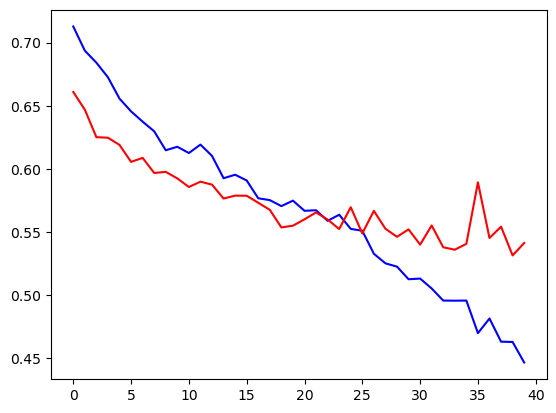

KeyError: 'accurracy'

In [12]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [25]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    confusion_matrix, fbeta_score, precision_recall_curve,
    average_precision_score, auc
)
import pandas as pd
def evaluation(x_test, y_test):
    # Make predictions for test data
#     shuffle_in_unison(x_test, y_test)
    y_pred = model.predict(x_test)[:, 0]
    pred = np.empty((1, len(y_pred)), dtype=object)
    pred = np.where(y_pred >= 0.5, 1, 0)
    y_test = np.reshape(y_test, len(y_test))
    pred = np.reshape(pred, len(pred))

    # Create confusion matrix for test data
    print('Validation for test data:')
    conf_matrix = pd.crosstab(y_test, pred)
    print(conf_matrix)

    # Calculate precision and recall
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    fbeta = fbeta_score(y_test, pred, beta=1)
    print('Accuracy: %.3f Precision: %.3f Recall: %.3f F_beta: %.3f' % (accuracy, precision, recall, fbeta))
evaluation(x_test, y_test)

18/18 [==============================] - 0s 9ms/step
Validation for test data:
col_0    0    1
row_0          
0.0    392  173
1.0      0    5
Accuracy: 0.696 Precision: 0.028 Recall: 1.000 F_beta: 0.055


We then use our trained net to classify the test set.

In [20]:
non_idx = np.where(y_test[:,0] == 0.)[0]
yes_idx = np.where(y_test[:,0] == 1.)[0]
y_hat = model.predict(x_test)[:,0]


18/18 [==============================] - 0s 9ms/step
[6.85638845e-01 8.46960902e-01 6.14286184e-01 9.38735783e-01
 9.54640269e-01 1.44988773e-02 2.40560845e-01 6.20673239e-01
 3.40587020e-01 3.35051805e-01 1.52151985e-02 2.86926866e-01
 2.23728761e-01 6.49702728e-01 2.78127998e-01 1.09986603e-01
 2.65913188e-01 6.84634373e-02 1.79537795e-02 3.10644478e-01
 3.13421302e-02 6.96159780e-01 6.06200732e-02 7.81611502e-01
 1.68082923e-01 6.03048384e-01 6.99066579e-01 8.59864891e-01
 5.33835649e-01 2.24543940e-02 4.59014028e-01 5.57463840e-02
 2.72458140e-02 3.89032245e-01 6.07636452e-01 2.86528081e-01
 2.78148860e-01 5.54279864e-01 3.03707998e-02 1.80116564e-01
 6.28408551e-01 1.77189037e-02 7.87658811e-01 3.50532010e-02
 2.87822355e-02 5.55549562e-02 4.32123423e-01 4.32662070e-02
 5.54307317e-03 3.92484851e-02 6.23444328e-03 5.08996725e-01
 5.58323085e-01 8.65626097e-01 8.97495210e-01 1.39770657e-02
 2.87158310e-01 2.14753766e-02 3.57009545e-02 6.64204180e-01
 3.23888421e-01 8.61252606e-01 1

 4.46524501e-01 4.31340367e-01] [[[ 3.99671175  0.49382045]
  [ 3.33690594  0.49386406]
  [ 2.8756792   0.49127113]
  ...
  [ 1.17568129  0.71887562]
  [ 9.01318149  0.71657284]
  [ 1.91163145  0.72139644]]

 [[ 3.42978333  1.92128223]
  [ 3.40752478  1.92159492]
  [ 3.41797006  1.9221042 ]
  ...
  [-1.49663212 -0.47721783]
  [-1.45326414 -0.48332917]
  [-1.29510142 -0.48723797]]

 [[ 7.26572373  0.2808922 ]
  [ 7.03515537  0.28464161]
  [ 6.63005897  0.28406711]
  ...
  [-1.33817525 -0.22713601]
  [-0.26273059 -0.22860195]
  [ 0.31322047 -0.23040404]]

 ...

 [[-3.31891675 -0.41757285]
  [-2.72808598 -0.41787185]
  [-2.55466399 -0.41498348]
  ...
  [ 0.23802805 -0.71259654]
  [ 0.77563622 -0.7141394 ]
  [ 1.02919113 -0.714259  ]]

 [[ 0.52981578  0.04694069]
  [ 0.50048279  0.04676194]
  [ 0.31312846  0.04728189]
  ...
  [ 0.02163182  0.01173117]
  [ 0.03156226  0.00979804]
  [ 0.15419048  0.00905224]]

 [[ 3.78931605  0.39318149]
  [ 3.43114208  0.39469584]
  [ 3.21543862  0.40066107

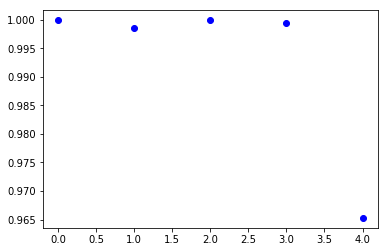

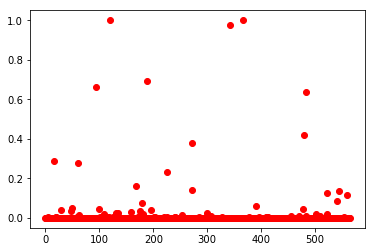

In [12]:
plt.plot([y_hat[i] for i in yes_idx], 'bo')
plt.show()
plt.plot([y_hat[i] for i in non_idx], 'ro')
plt.show()

These graphs show that the five positive examples all get 0.95-1.00 score. Also, almost all negative examples get score close to zero, except a few in the 0.9-1.0 range. This is encouraging.

We now choose an optimal cutoff score for classification. Sklearn can help us with this.

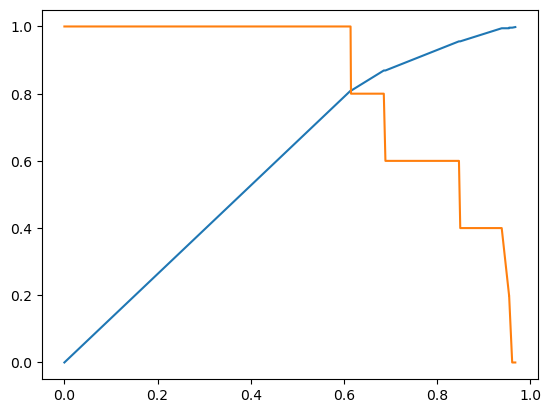

Crossover at 0.61 with specificity 0.81


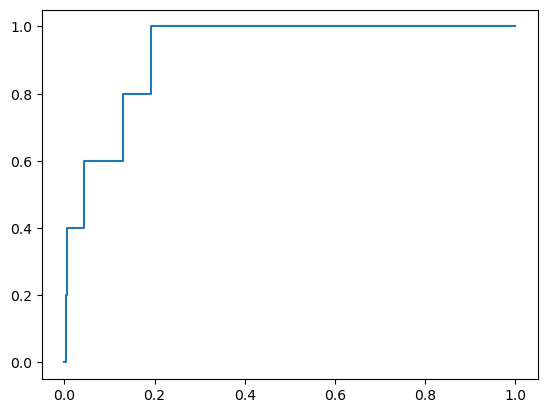

ROC area under curve is 0.92


In [19]:
from sklearn.metrics import confusion_matrix, precision_score
y_true = (y_test[:, 0] + 0.5).astype("int")
fpr, tpr, thresholds = roc_curve(y_true, y_hat)
plt.plot(thresholds, 1.-fpr)
plt.plot(thresholds, tpr)
plt.show()
crossover_index = np.min(np.where(1.-fpr <= tpr))
crossover_cutoff = thresholds[crossover_index]
crossover_specificity = 1.-fpr[crossover_index]
print("Crossover at {0:.2f} with specificity {1:.2f}".format(crossover_cutoff, crossover_specificity))
plt.plot(fpr, tpr)
plt.show()
print("ROC area under curve is {0:.2f}".format(roc_auc_score(y_true, y_hat)))

precision_score(y_true, y_hat)

Let's take a look at the misclassified data (if any):

124


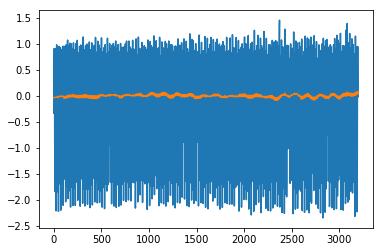

347


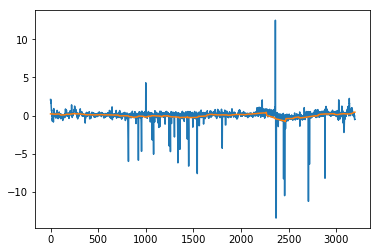

372


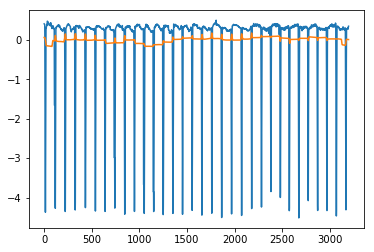

In [14]:
false_positives = np.where(y_hat * (1. - y_test) > 0.5)[0]
for i in non_idx:
    if y_hat[i] > crossover_cutoff:
        print(i)
        plt.plot(x_test[i])
        plt.show()

It seems NASA missed one planet. I take this opportunity to claim it, and hereby name it Kaggle alpha :)